<h1>Setup</h1>

In [3]:
import pandas as pd
import streamlit as st
import sklearn as sk
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tsfresh

2023-05-05 23:10:11.297 INFO    numba.cuda.cudadrv.driver: init


In [4]:
path = r"C:\Users\ReneJ\Desktop\Data"

<h1>Testsachen mit Lichtsensor und Bildschirmhelligkeit</h1>

In [117]:
#CSVs einlesen und DataFrames bauen. Weirde Spalten löschen und ne richtige Zeite Spalte hinzufügen

light = pd.read_csv(path+ r"\2023-04-22_08-09-30\Light.csv")
displayB = pd.read_csv(path + r"\2023-04-22_08-09-30\Brightness.csv")
battery = pd.read_csv(path + r"\2023-04-22_08-09-30\Battery.csv")
location = pd.read_csv(path + r"\2023-04-22_08-09-30\Location.csv")

dfs =[light, displayB, battery, location]

light["Time"] = pd.to_datetime(light['time'], unit = 'ns')
light.drop(columns=["time", "seconds_elapsed"])

displayB["Time"] = pd.to_datetime(displayB["time"], unit = 'ns')
displayB.drop(columns=["time", "seconds_elapsed"])

battery["Time"] = pd.to_datetime(battery['time'], unit = 'ns')
battery.drop(columns=["time", "seconds_elapsed"])

location["Time"] = pd.to_datetime(location['time'], unit = 'ns')
location.drop(columns=["time", "seconds_elapsed"])

type(location["Time"][0])
location["Time"][0].to_pydatetime()


for df in dfs:
    df["Readable_Time"] = df["Time"]
    for i in range(0,len(df["Time"])):
        df["Readable_Time"][i] = df["Time"][i].to_pydatetime()

light


C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: UserWarning: Discarding nonzero nanoseconds in conversion.
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is tryi

,time,seconds_elapsed,lux,Time,Readable_Time
0,1682150970343186200,-0.031814,361,2023-04-22 08:09:30.343186200,2023-04-22 08:09:30.343186
1,1682150970600927200,0.225927,361,2023-04-22 08:09:30.600927200,2023-04-22 08:09:30.600927
2,1682150970721837800,0.346838,363,2023-04-22 08:09:30.721837800,2023-04-22 08:09:30.721837
3,1682150970782262800,0.407263,365,2023-04-22 08:09:30.782262800,2023-04-22 08:09:30.782262
4,1682150970842687500,0.467687,363,2023-04-22 08:09:30.842687500,2023-04-22 08:09:30.842687
...,...,...,...,...,...
130200,1682205732018796500,54761.643797,9,2023-04-22 23:22:12.018796500,2023-04-22 23:22:12.018796
130201,1682205732200101600,54761.825102,6,2023-04-22 23:22:12.200101600,2023-04-22 23:22:12.200101
130202,1682205732639890400,54762.264890,9,2023-04-22 23:22:12.639890400,2023-04-22 23:22:12.639890
130203,1682205732821958100,54762.446958,11,2023-04-22 23:22:12.821958100,2023-04-22 23:22:12.821958


<Axes: xlabel='Time'>

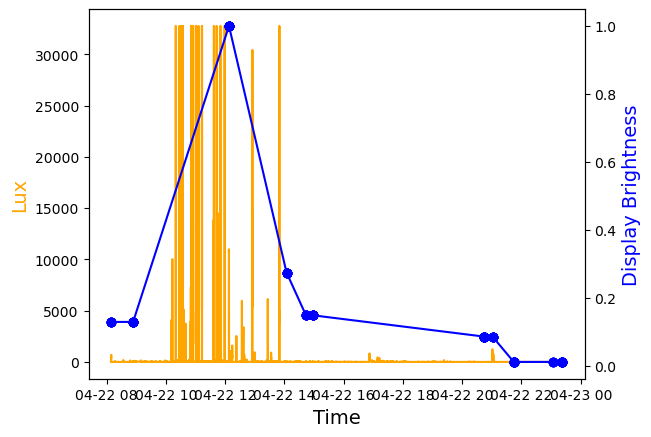

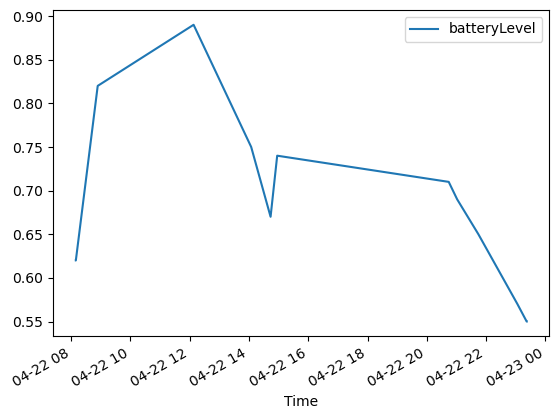

In [118]:
#light.plot(x= "Time", y = "lux")
#displayB.plot(x = "Time", y = "brightness")


fig = plt.subplot()
ax = plt.subplot()
ax.plot(light["Readable_Time"], light["lux"], color = "orange")
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Lux", color = "orange", fontsize = 14)

ax2 = ax.twinx()
ax2.plot(displayB["Readable_Time"], displayB["brightness"], color = "blue", marker = "o")
ax2.set_ylabel("Display Brightness", color = "blue", fontsize = 14)

plt.show

battery.plot(x = "Time", y = "batteryLevel")

<h1>Beschleunigungsdaten ML Modell</h1>

In [119]:
def transform_data(df, action = ""):
    df["time"] = pd.to_datetime(df['time'], unit = 'ns')

    df = df.query("sensor == 'Accelerometer'")

    df["Readable_Time"] = df["time"]
    for i in range(0,len(df["time"])):
        df["Readable_Time"][i] = df["time"][i].to_pydatetime()

    df = df.drop(columns= df.columns.difference(["z", "y", "x", "Readable_Time"]))
    
    df["action"] = ""
    for i in range(0,len(df["Readable_Time"])):
        df["action"][i] = action
    return df

In [120]:
#Acceleration Preparation
jump = pd.read_json(path+ r"\WJR_Detection\Jump-2023-04-27_19-42-18.json")
walk = pd.read_json(path+ r"\WJR_Detection\Walk-2023-04-27_19-40-51.json")
stand = pd.read_json(path+ r"\WJR_Detection\Standing-2023-04-27_19-44-03.json")

jump_test = pd.read_json(path+ r"\WJR_Detection\Jump_Test-2023-04-28_10-00-59.json")
walk_test = pd.read_json(path+ r"\WJR_Detection\Walk_Test-2023-04-28_10-00-09.json")
stand_test = pd.read_json(path+ r"\WJR_Detection\Stand_Test-2023-04-28_09-59-11.json")

jump = transform_data(jump, "jump")
walk = transform_data(walk, "walk")
stand = transform_data(stand, "stand")
jump_test = transform_data(jump_test, "jump")
walk_test = transform_data(walk_test, "walk")
stand_test = transform_data(stand_test,"stand")
   
training = pd.concat([jump, walk, stand])
test = pd.concat([jump_test, walk_test, stand_test])

training

C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"] = df["time"]
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:8: UserWarning: Discarding nonzero nanoseconds in conversion.
  df["Readable_Time"][i] = df["time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:14: SettingW

,z,y,x,Readable_Time,action
0,0.000000,0.000000,0.000000,2023-04-27 19:42:18.277185,jump
1,0.535316,0.107452,-0.016647,2023-04-27 19:42:18.297204,jump
2,1.326960,0.094828,-0.065196,2023-04-27 19:42:18.315912,jump
3,1.473503,0.272366,0.114777,2023-04-27 19:42:18.337579,jump
4,1.516916,0.702033,-0.020280,2023-04-27 19:42:18.357751,jump
...,...,...,...,...,...
3046,0.350914,-0.337229,0.086209,2023-04-27 19:45:04.948845,stand
3047,0.332034,-0.287460,0.245507,2023-04-27 19:45:04.969078,stand
3048,0.178136,-0.188401,0.360048,2023-04-27 19:45:04.987785,stand
3049,-0.124652,-0.086617,0.011765,2023-04-27 19:45:05.009361,stand


In [121]:
features = ["x","y","z"]
predict = "action"

xTrain = training[features]
yTrain = training[predict]

#### Test 1 ####

xTest = test[features]
yTest = test[predict]

rfc = RandomForestClassifier(random_state= 5)
rfc = rfc.fit(xTrain,yTrain)

y_prediction = rfc.predict(xTest)


print("Test 1 : Accuracy is " + str(accuracy_score(yTest, y_prediction)*100))
#print(yTest)

compare = pd.DataFrame(y_prediction, columns= ["predicted_action"])


compare = compare.join(yTest)


print(compare)


Test 1 : Accuracy is 76.27937623544916
     predicted_action action
0                walk   jump
0                walk   walk
0                walk  stand
1                walk   jump
1                walk   walk
...               ...    ...
4548            stand    NaN
4549            stand    NaN
4550            stand    NaN
4551            stand    NaN
4552            stand    NaN

[7555 rows x 2 columns]


In [122]:
training.to_csv(path+ "\WJS_Training.csv")
test.to_csv(path+ "\WJS_Test.csv")
compare.to_csv(path + "\compare.csv")

<Axes: xlabel='Readable_Time'>

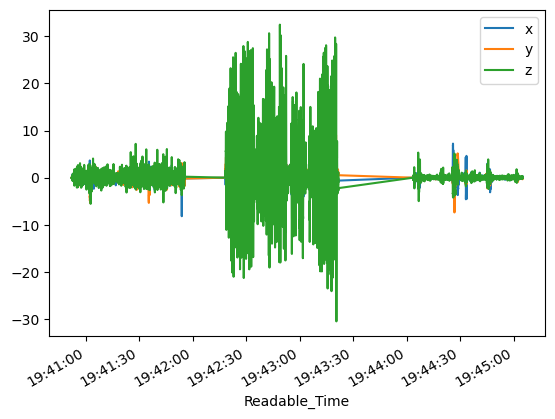

In [123]:
training.plot(x = "Readable_Time", y= ["x", "y", "z"])

<h1>Der heiße Scheiß! Timeseries Classification for Mobility!</h1>

Das Vorgehen / meine Idee dazu, wie der Kram überhaupt funktionieren soll, hier fix dokumentiert:

Wir suchen uns aus den gesammelten Daten ~3 Sensoren aus, die wir für sinnvoll für die Klassifizierung halten (ich denke an Accelerometer, vom GPS das Speed Attribut und vlt noch der Lichtsensor). 

Wir reduzieren die Sensordaten einer Aufnahme dann auf diese Daten. Die Granularität der Daten ist egal, sie müssen auch nicht aufeinader gejoint werden. 

Für diese Daten werden Kennzahlen ausgerechnet, die Kennzahlen werden dann in einem Dataframe gespeichert und für das ML Modell zum trainieren verwendet.

In [5]:
sensors = ["Accelerometer","Location","Brightness"]
path = r"C:\Users\ReneJ\Desktop\Data"

<h3>Datenmassenvorverarbeitungsmethoden</h3>

Mit den beiden unten stehenden Methoden können wir super schnell und automatisiert Daten einlesen und umformatieren. Die Methoden machen beide da gleiche, die eine ist für CSVs, die andere für JSONs.

*transform_data_csv()* bekommt als Parameter einaml *folder* und *action*. *folder* ist der Dateipfad zum Ordner, in dem die ganzen Sensordaten im CSV Format liegen. Die Daten werden über den Dateipfad path(siehe oben) + folder (Parameter) + sensor (Einträge aus der *sensors* List, auch hier, siehe oben) gelsesen.

Bei *transform_data_json* gibt es den Parameter *folder* nicht, sondern den Parameter *subpath*. Im der JSON Datei sind alle Sensordaten enthalten und werden nicht gesplittet, anders als bei den CSVs, da ist jede CSV ein Sensor. Daher kann man hier einfach direkt den restlichen Dateipfad übergeben. Die JSON Dateien werden dann über den Pfad path (siehe oben) + subpath (der Parameter) eingelesen.

**Beide** Methoden haben den Parameter *action*. Dieser gibt an, zu welcher Aktivität die eingelesenen Daten gehören (Auto, Fahrrad, Laufen, Bus, Ubahn, Stehen)


Beide Methoden geben am Ende ein **Dictionary** zurück. Das Dictionary ist bei beiden Methoden im selben Format. Dieses Dictionary weist den Sensornamen (z.B. "Accelerometer") einen Dataframe zu. Außerdem speichert das Dictionary die Aktivität noch dazu. Jeder Dataframe hat eine eindeutige ID, diese hat den selben Wert wie *folder* oder *subpath*


In [7]:
#SUPER WICHTIG! folder ist ein Teil des Paths der Datei! Wegen des Aufbaus der Pathschnipsel, die ich hier verwende, muss folder mit einem \ anfangen und mit einem \ aufhören
def transform_data_csv(folder, action = ""):  
    datasets = {} #Ein Dictionary
    datasets["activity"] = action #Die Transportart wird im Dictionary gespeichert
    for sensor in sensors:
        #Dataframe wird eingelesen
        df = pd.read_csv(path + folder + sensor + ".csv")

        #Zeittransformation
        df["time"] = pd.to_datetime(df['time'], unit = 'ns')
        df["Readable_Time"] = df["time"]
        for i in range(0,len(df["time"])):
            df["Readable_Time"][i] = df["time"][i].to_pydatetime()
        df = df.drop(columns=["time", "seconds_elapsed"])
        df = df.dropna(axis = 1)

        #Datenschutz. Falls Location ein Sensor ist, wird davon nur die Speed verwendet
        if(sensor == "Location"):
            df = df.drop(columns= df.columns.difference(["speed", "Readable_Time"]))

        #df["activity"] = action #Darf hier nicht gesetzt werden, ist aber im Dicitonary vermerkt
        df["ID"] = folder
        
        #Dataframe wird dem Dictionay hinzugefügt
        datasets[sensor] = df
        
    return datasets



In [9]:
def transform_data_json(subPath, action = ""):
    datasets = {} #Ein Dictionary
    datasets["activity"] = action #Die Transportart wird im Dictionary gespeichert

    df = pd.read_json(path + subPath)

    #Zeittransformation
    df["time"] = pd.to_datetime(df['time'], unit = 'ns')
    df["Readable_Time"] = df["time"]
    for i in range(0,len(df["time"])):
        df["Readable_Time"][i] = df["time"][i].to_pydatetime()
    df = df.drop(columns=["time", "seconds_elapsed"])
    
    for sensor in sensors:
        temp = df.loc[df["sensor"] == sensor]
        temp = temp.dropna(axis = 1)
        temp = temp.drop(columns=["sensor"])
        #Datenschutz. Falls Location ein Sensor ist, wird davon nur die Speed verwendet
        if(sensor == "Location"):
            temp = temp.drop(columns= temp.columns.difference(["speed", "Readable_Time"]))

        #temp["activity"] = action #Darf hier nicht gesetzt werden, ist aber im Dicitonary vermerkt
        temp["ID"] = subPath
            
        #Dataframe wird dem Dictionary hinzugefügt
        datasets[sensor] = temp

    return datasets


<h3>Datentransformation mittels tsfresh</h3>
Die Codezeile

features = tsfresh.extract_features(Dictionary[Key zum Dataframe], column_id = "ID",column_sort='Readable_Time', 
                                       default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())

oder auch 

features = tsfresh.extract_features(Dictionary[Key zum Dataframe], column_id = "ID",column_sort='Readable_Time')

ist super duper wichtig. Mit ihr wird ein Dataframe zu einem neuen Dataframe umgewandelt. Der neue Dataframe besteht aus einer Zeile und n Spalten, wobei jede Spalte eine Metrik ist, die über die Ursprungsdataframe berechnet wurde. Das ist das Format, über das unser ML Modell trainieren wird. Dem neuen Dataframe muss man noch eine Spalte hinzufügen, in der steht, zu welcher Aktivität die Zeile gehört

___________________________________________________________________


Anyways, was zum Code hier unter mir: Mach ich morgen

In [10]:
car_csvs ={
    "data" : ["\CSVs\Car-2023-05-04_09-47-00\\"],
    "activity" :"car"
    }
bike_csvs = {
    "data" : [],
    "activity" : "bike"
    }
walk_csvs = {
    "data" : ["\CSVs\Walking2-2023-05-05_10-48-56\\"],
    "activity" : "walk"
    }
bus_csvs = {
    "data" : [],
    "activity" : "bus"
    }
subway_csvs = {
    "data" : [],
    "activity" : "subway"
    }  
idle_csvs = {
    "data" : [],
    "activity" : "idle"
    }
#-----------------------------
#"\JSON\.json"
car_jsons= {
    "data" : [],
    "activity" : "car"
    }
bike_jsons = {
    "data" : ["\JSON\Bike_-2023-04-30_13-14-29.json", "\JSON\Bike-2023-04-30_13-19-50.json", "\JSON\Bike-2023-04-30_18-19-23.json"],
    "activity" : "bike"
    }
walk_jsons = {
    "data" : ["\JSON\Walk_(Partial_Run)-2023-05-01_20-34-13.json", "\JSON\Walk_(quite_fast)-2023-05-01_16-36-48.json", "\JSON\Walk_(Stairs)-2023-04-30_18-33-43.json", "\JSON\Walk-2023-04-30_13-30-37.json"],
    "activity" : "bike"
    }
bus_jsons = {
    "data" : [],
    "activity" : "bike"
    }
subway_jsons = {
    "data" : ["\JSON\Subway_-2023-05-01_20-51-16.json", "\JSON\Subway-2023-05-01_16-43-39.json"],
    "activity" : "subway"
    }
idle_jsons = {
    "data" : [],
    "activity" : "idle"
    }

data_csv = [car_csvs, bike_csvs, walk_csvs, bus_csvs, subway_csvs, idle_csvs]
data_json = [car_jsons, bike_jsons, walk_jsons, bus_jsons, subway_jsons, idle_jsons]

<h3>Schritt 1</h3>

Alle Daten aus den beiden Listen voller Dictionaries werden mit den Methoden *transform_data_csv()* und *transform_data_json()* zu Dictionaries transformiert (siehe Beschreibung der Methoden). Diese Dicts werden in der Liste *transformed_data_list* gespeichert

In [ ]:
transformed_data_list = []

for dict in data_csv:
    for data in dict["data"]:
        transformed_data_list.append(transform_data_csv(data, dict["activity"]))
for dict in data_json:
    for data in dict["data"]:
        transformed_data_list.append(transform_data_json(data, dict["activity"]))

<h3>Schritt 2</h3>

Die Daten werden mit tsfresh zu Kennzahlen umgewandelt. Für jedes Dictionary in der *transformed_data_list* wird für jeden Sensor aus der Sensor-Liste der in dem Dict gespeicherte Dataframe zu Kennzahlen mit tsfresh umgewandelt. Denn jedes dictionary hat für jeden Sensor aus der List einen Dataframe gespeichert. Die Kennzahlen werden als ein neuer Dataframe gespeichert, diesem Dataframe wird noch das Attribut "Activity" hinzugefügt, dieses speichert die Fortbewegungsart. Der Wert dafür kommt aus dem Dictionary.

Jeder Kennzahlendataframe hat genau eine Reihe.

In der Liste *final_form_data_list* wird jeder einzeilige Kennzahlen-Dataframe zusammen mit der Sensorart des Kennzahlen-Dataframes als ein Dictionary gespeichert.

In [37]:
final_form_data_list = []

for dict in transformed_data_list:
    for sensor in sensors:
        temp = tsfresh.extract_features(dict[sensor], column_id = "ID",column_sort='Readable_Time',
                                        default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
        temp["activity"] = dict["activity"]
        #temp["ID"] = dict[sensor]["ID"]
        final_form_data_list.append({"data" : temp, "sensor" : sensor})

2023-05-05 23:55:42.462 WARNING tsfresh.feature_extraction.settings: Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]
2023-05-05 23:55:44.881 WARNING tsfresh.feature_extraction.settings: Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
2023-05-05 23:55:47.252 WARNING tsfresh.feature_extraction.settings: Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]
2023-05-05 23:55:49.597 WARNING tsfresh.feature_extraction.settings: Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
2023-05-05 23:55:52.167 WARNING tsfresh.feature_extraction.settings: Dependency not available for matrix_profile, this feature will be disabled!
Feature Ext

In [34]:
final_form_data_list[0]


{'data':                                 z__sum_values  z__median   z__mean  z__length  \
 \CSVs\Car-2023-05-04_09-47-00\  -10107.824987  -0.107351 -0.119138    84841.0   
 
                                 z__standard_deviation  z__variance  \
 \CSVs\Car-2023-05-04_09-47-00\               0.736834     0.542924   
 
                                 z__root_mean_square  z__maximum  \
 \CSVs\Car-2023-05-04_09-47-00\             0.746403   30.836572   
 
                                 z__absolute_maximum  z__minimum  ...  \
 \CSVs\Car-2023-05-04_09-47-00\            31.614528  -31.614528  ...   
 
                                  x__mean  x__length  x__standard_deviation  \
 \CSVs\Car-2023-05-04_09-47-00\  0.029837    84841.0               0.745146   
 
                                 x__variance  x__root_mean_square  x__maximum  \
 \CSVs\Car-2023-05-04_09-47-00\     0.555242             0.745743   19.883466   
 
                                 x__absolute_maximum  x__minimum  activi

<h3>Schritt 3 </h3>

Nun werden die ganzen Dataframes mit den gleichen Sensoren zu jeweils einem kombiniert. Also wenn ich am Ende von Schritt 2 drei Accelerometer dfs, drei Location dfs und drei Orientation dfs hatte, hab ich am Ende von Schritt drei einen Accelerometer df, einen Location df und einen Orientation df mit jeweils drei Zeilen.

Diese Dataframes werden alle in der Liste *very_final_form_data_list* gespeichert. Ich weiß, meine Listennamen sind einfach top tier xD.

In [38]:
very_final_form_data_list = []

for sensor in sensors:
    temp_list = []
    for dict in final_form_data_list:
        if str(dict["sensor"]) == str(sensor):
            temp_list.append(dict["data"])
    concat_temp = pd.concat(temp_list)
    very_final_form_data_list.append(concat_temp)

<h3>Schritt 4</h3>

Der letzte Schritt zur Datentransformation und auch der trivialste. Die Dataframes aus der Liste *very_final_form_data_list* werden konkateniert. Da der Index von allen Dataframes hier die eindeutige ID ist, sollte man die einfach so ohne Probleme aneinanderlegen können, ohne großartige Join-Logik. 

Die Spalte "activity" ist nun n Mal vorhanden, die Duplikatspalten werden dann entfernt.

Sämtliche Daten aus den 12 Dictionaries von vor Schritt 1 sind nun transformiert in dem Dataframe *df_final* gespeichert.

In [52]:
#Join all the Dataframes to one Dataframe
df_final = pd.concat(very_final_form_data_list, axis = 1)

#Drop duplicate "activity" Columns
d = df_final.T.drop_duplicates().T
d["activity"]
df_final = df_final.drop(columns=["activity"])
df_final["activity"] = d["activity"]

#Final Dataframe with all the transformed data
df_final

,z__sum_values,z__median,z__mean,z__length,z__standard_deviation,z__variance,z__root_mean_square,z__maximum,z__absolute_maximum,z__minimum,...,brightness__median,brightness__mean,brightness__length,brightness__standard_deviation,brightness__variance,brightness__root_mean_square,brightness__maximum,brightness__absolute_maximum,brightness__minimum,activity
\CSVs\Car-2023-05-04_09-47-00\,-10107.824987,-0.107351,-0.119138,84841.0,0.736834,0.542924,0.746403,30.836572,31.614528,-31.614528,...,0.000000,0.018988,840.0,0.123344,0.015214,0.124797,0.950000,0.950000,0.000000,car
\CSVs\Walking2-2023-05-05_10-48-56\,63909.050626,0.237775,0.214350,298153.0,2.155290,4.645276,2.165923,45.310388,45.412553,-45.412553,...,0.000000,0.013241,2953.0,0.096462,0.009305,0.097366,1.000000,1.000000,0.000000,walk
\JSON\Bike_-2023-04-30_13-14-29.json,-12.890468,0.013662,-0.000955,13498.0,1.920423,3.688025,1.920423,17.304626,29.972021,-29.972021,...,1.000000,1.000000,2.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,bike
\JSON\Bike-2023-04-30_13-19-50.json,-112.785282,0.025493,-0.003679,30659.0,1.657747,2.748124,1.657751,16.356148,19.077936,-19.077936,...,1.000000,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,bike
\JSON\Bike-2023-04-30_18-19-23.json,-196.462159,0.041513,-0.005145,38184.0,1.775993,3.154150,1.776000,14.217209,22.957998,-22.957998,...,0.192157,0.192157,2.0,0.000000,0.000000,0.192157,0.192157,0.192157,0.192157,bike
\JSON\Walk_(Partial_Run)-2023-05-01_20-34-13.json,93.768498,-0.008937,0.002223,42183.0,4.083458,16.674632,4.083459,32.049389,37.712906,-37.712906,...,0.011765,0.011765,4.0,0.000000,0.000000,0.011765,0.011765,0.011765,0.011765,bike
\JSON\Walk_(quite_fast)-2023-05-01_16-36-48.json,336.532044,-0.074012,0.038351,8775.0,5.201088,27.051312,5.201229,31.904240,31.904240,-27.883728,...,0.462745,0.462745,3.0,0.000000,0.000000,0.462745,0.462745,0.462745,0.462745,bike
\JSON\Walk_(Stairs)-2023-04-30_18-33-43.json,-27.838024,0.014137,-0.004734,5880.0,3.259027,10.621258,3.259031,20.445541,20.445541,-11.145182,...,0.192157,0.192157,7.0,0.000000,0.000000,0.192157,0.192157,0.192157,0.192157,bike
\JSON\Walk-2023-04-30_13-30-37.json,-352.500591,-0.031102,-0.056077,6286.0,2.952131,8.715075,2.952663,26.982586,26.982586,-15.454446,...,1.000000,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,bike
\JSON\Subway_-2023-05-01_20-51-16.json,23.184944,-0.002092,0.002016,11501.0,0.561489,0.315270,0.561493,10.425532,10.425532,-5.529358,...,0.011765,0.011765,6.0,0.000000,0.000000,0.011765,0.011765,0.011765,0.011765,subway
